In [9]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import csv
import os
import subprocess
import gc
print("uproot version",uproot.__version__)
print("awkward version",ak.__version__)
print("numpy version",np.__version__)
print("matplotlib version",matplotlib.__version__)
print("hist version",hist.__version__)
print("vector version",vector.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1


In [3]:
csv_file_path = '../data/counters.online.csv'
run=[]
with open(csv_file_path, newline='') as csvfile :
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        run.append(row['run'])
    
print([int(r) for r in run])

[290222, 290223, 290254, 290293, 290297, 290300, 290323, 290324, 290327, 290350, 290374, 290375, 290401, 290404, 290411, 290418, 290420, 290421, 290423, 290425, 290427, 290428, 290456, 290458, 290459, 290467, 290469, 290499, 290501, 290538, 290539, 290540, 290544, 290549, 290550, 290553, 290590, 290612, 290613, 290614, 290615, 290627, 290632, 290645, 290658, 290660, 290665, 290687, 290692, 290696, 290699, 290721, 290742, 290764, 290766, 290769, 290774, 290776, 290787, 290790, 290848, 290853, 290860, 290862, 290892, 290894, 290895, 290932, 290935, 290943, 290944, 290948, 290975, 290976, 290979, 290980, 291002, 291003, 291004, 291005, 291006, 291035, 291037, 291041, 291065, 291066, 291100, 291110, 291263, 291265, 291282, 291283, 291284, 291285, 291286, 291360, 291361, 291362, 291363, 291373, 291375, 291397, 291399, 291400, 291402, 291416, 291417, 291419, 291420, 291446, 291447, 291451, 291453, 291456, 291457, 291481, 291482, 291484, 291485, 291590, 291614, 291615, 291618, 291622, 291624,

In [4]:
#for r in run :
    #!ls -alh /pbs/throng/training/nantes-m2-rps-exp/data/*290222*
    #!ls -alh /pbs/throng/training/nantes-m2-rps-exp/data/*291223*
    #!ls -alh /pbs/throng/training/nantes-m2-rps-exp/data/*292242*

In [10]:
vector.register_awkward() 
DATATYPE="mc"
assert((DATATYPE=="mc")  or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root" ;

#import pandas
#l1 = pandas.read_csv('../data/counters.offline.csv')['run']
#l2 = [int(e) for e in os.popen("ls /pbs/throng/training/nantes-m2-rps-exp/data/ | grep 'mc' | cut -c 4-9").read().split('\n')[0:-2]]
#print(len(l2))
#print(l2) 

In [22]:
SAMPLE_RUNS=[290323, 290327, 290374, 290375, 290404, 290420, 290421, 290423, 290425, 290427,  290456, 290458, 290459, 290469, 290501, 290539, 290540, 290549, 290553, 290590, 290612, 290632, 290658, 290660, 290687, 290692, 290696, 290699, 290742, 290764, 290766, 290776, 290787, 290848, 290853, 290860, 290894, 290895, 290932, 290935, 290975, 290980, 291002, 291003, 291004, 291005, 291041, 291263, 291283, 291284, 291285, 291360, 291361, 291362, 291373, 291399, 291400, 291447, 291451, 291453, 291482, 291485, 291590, 291618, 291622, 291624, 291657, 291690, 291692, 291694, 291698, 291706, 291755, 291760, 291769, 291795, 291796, 291803, 291943, 291944, 291948, 291953, 291976, 291982, 292012, 292040, 292060, 292061, 292062, 292075, 292077, 292080, 292106, 292108, 292109, 292115, 292140, 292160, 292162, 292163, 292164, 292166, 292168, 292192, 292242, 292265, 292269, 292270, 292273, 292274]

JPsiGen=[]
Psi2SGen=[]

for i in SAMPLE_RUNS[0:5] :
    nofJPsiGen=0
    nofPsi2SGen=0
    nofEvents =0
    nofTracks=0
    file = uproot.open(data_file_path(i,IS_MC));
    events = file["eventsTree"]
    gen=file["genTree"]
    g= gen.arrays(["nMuonsGen", "Muon_GenE", "Muon_GenPx","Muon_GenPy","Muon_GenPz", "Muon_GenLabel", "Muon_GenMotherPDGCode"], how="zip", entry_stop=150000)

    m = events.arrays(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",entry_stop=150000)
    """for event in g :
        nofEvents+=1
        tracks = event["Muon"].to_list()
        for t in tracks:
            nofTracks+=1
            if t["GenMotherPDGCode"]==443 :
                nofJPsiGen +=1
            if t["GenMotherPDGCode"]== 100443 :
                nofPsi2SGen +=1
        print(nofJPsiGen + nofPsi2SGen)
        print(nofTracks)
        JPsiGen.append(nofJPsiGen)
        Psi2SGen.append(nofPsi2SGen)"""
        
#print(g)
ak.Array(g)
print(ak.sum(ak.Array(g)["Muon_GenMotherPDGCode"]==443))
        
    
#file = uproot.open("/pbs/throng/training/nantes-m2-rps-exp/data/run290860.mc.root")

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290323} . {'mc'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290327} . {'mc'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290374} . {'mc'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290375} . {'mc'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290404} . {'mc'} .root


FieldNotFoundError: no field 'Muon_GenMotherPDGCode' in record with 2 fields

This error occurred while attempting to slice

    <Array [{nMuonsGen: 2, Muon: ..., ...}, ...] type='80000 * {nMuonsGen: ...'>

with

    'Muon_GenMotherPDGCode'

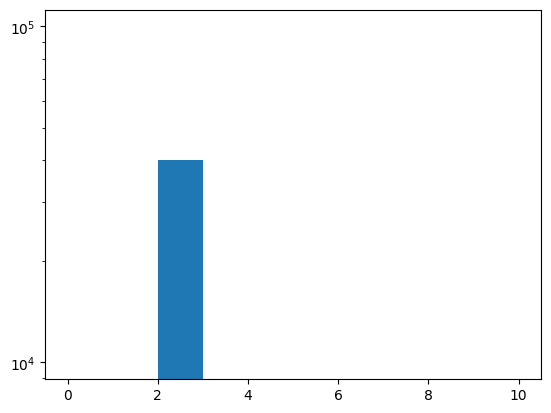

In [7]:
    plt.hist(g.nMuonsGen,bins=[0,1,2,3,4,5,6,7,8,9,10]) #nbr muons par event
    plt.yscale("log")

In [8]:
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
nofJPsiGen=0
nofJPsi2SGen=0
for event in g :
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        if t["GenMotherPDGCode"]==443 :
            nofJPsiGen +=1
        if t["GenMotherPDGCode"]== 100443 :
            nofJPsi2SGen +=1
        
print(nofEvents, nofTracks, nofJPsiGen/2, nofJPsi2SGen/2)
print(nofJPsiGen/2 + nofJPsi2SGen/2)

40000 80000 26733.0 13267.0
40000.0
